In [1]:
import numpy as np
import pandas as PD
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from pathlib import Path
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

# Part 1

In [2]:
# Load dataset

ROOT = Path('__file__').parent

data_paths = {
    'disgust': ROOT / 'dataset' / 'disgust',
    'surprise': ROOT / 'dataset' / 'surprise',
    'happy': ROOT / 'dataset' / 'happy',
    'neutral': ROOT / 'dataset' / 'neutral'
}

category2int = {
    k: i for i, k in enumerate(data_paths.keys())
}

ORIGINAL_SHAPE = (600, 300)
images = []
labels = []
FACE_SLICE = (slice(120, -120), slice(25, -25))

for category, path in data_paths.items():
    for img_name in Path.iterdir(path):
        img = cv2.imread(str(img_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = img[FACE_SLICE]
        img = img.flatten().reshape(1, -1)
        images.append(img)
        labels.append(category2int[category])

# Convert to numpy arrays
images = np.concatenate(images, axis=0)
labels = np.array(labels)

In [3]:
# Split dataset

test_size = {
    'disgust': 30,
    'surprise': 60,
    'happy': 60,
    'neutral': 120
}

train_idx = []
test_idx = []

for category, size in test_size.items():
    label = category2int[category]
    all_idx = np.random.permutation(np.where(labels == label)[0])
    train_idx.append(all_idx[:size])
    test_idx.append(all_idx[size:])

train_idx = np.concatenate(train_idx)
test_idx = np.concatenate(test_idx)

In [4]:
X_train_orig = images[train_idx, :]
y_train_orig = labels[train_idx]
X_test_orig = images[test_idx, :]
y_test_orig = labels[test_idx]

print(f'X_train shape: {X_train_orig.shape}')
print(f'X_test shape: {X_test_orig.shape}')
print(f'y_train shape: {y_train_orig.shape}')
print(f'y_test shape: {y_test_orig.shape}')

X_train shape: (270, 90000)
X_test shape: (140, 90000)
y_train shape: (270,)
y_test shape: (140,)


In [5]:
# Apply PCA
N_DIMS = 50
pca = PCA(n_components=N_DIMS)
pca.fit(X_train_orig)
X_train_orig = pca.transform(X_train_orig)
X_test_orig = pca.transform(X_test_orig)

print(f'X_train shape: {X_train_orig.shape}')
print(f'X_test shape: {X_test_orig.shape}')

X_train shape: (270, 50)
X_test shape: (140, 50)


In [6]:
C_VALS = [0.01, 0.03, 0.1, 0.3, 1, 3, 10]
accuracies = []

for C in C_VALS:
    X_train, X_val, y_train, y_val = train_test_split(X_train_orig, y_train_orig, shuffle=True)
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_val = scaler.transform(X_val)

    clf = SVC(C=C, kernel='linear')
    clf.fit(X_train, y_train)
    y_val_pred = clf.predict(X_val)
    
    acc = np.mean(y_val == y_val_pred)
    print(f'C: {C}, acc: {np.round(acc, 3) * 100}%')
    accuracies.append(acc)

C: 0.01, acc: 82.39999999999999%
C: 0.03, acc: 85.3%
C: 0.1, acc: 89.7%
C: 0.3, acc: 89.7%
C: 1, acc: 86.8%
C: 3, acc: 85.3%
C: 10, acc: 89.7%


In [7]:
best_c_idx = np.argmax(accuracies)
best_c = C_VALS[best_c_idx]
best_c

0.1

116.1895003862225
============ Classification metrics ============
              precision    recall  f1-score   support

           0       0.80      0.71      0.75        17
           1       0.93      0.89      0.91        28
           2       0.92      0.88      0.90        25
           3       0.89      0.94      0.92        70

    accuracy                           0.89       140
   macro avg       0.88      0.86      0.87       140
weighted avg       0.89      0.89      0.89       140



<Axes: >

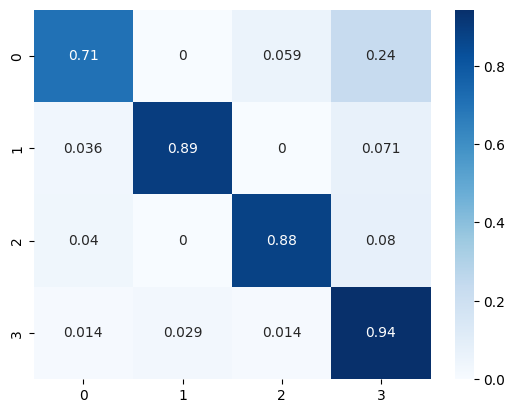

In [8]:
X_train = X_train_orig.copy()
y_train = y_train_orig.copy()
X_test = X_test_orig.copy()
y_test = y_test_orig.copy()
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print(np.linalg.norm(X_train))

clf = SVC(C=best_c, kernel='linear')
clf.fit(X_train, y_train)
y_test_preds = clf.predict(X_test)

print('============ Classification metrics ============')
print(classification_report(y_test, y_test_preds))
sns.heatmap(confusion_matrix(y_test, y_test_preds, normalize='true'), annot=True, cmap='Blues')

# Part 2

In [14]:
C_VALS = np.logspace(-4, 2, 20)
GAMMA_VALS = np.logspace(-4, 2, 20)

parameters = {
    'C': C_VALS,
    'gamma': GAMMA_VALS
}

clf = GridSearchCV(SVC(kernel='rbf'), parameters)
clf.fit(X_train_orig, y_train_orig)
print(f'Best parameters: {clf.best_params_}')

Best parameters: {'C': 0.0001, 'gamma': 0.0001}


============ Classification metrics ============
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.00      0.00      0.00        28
           2       0.00      0.00      0.00        25
           3       0.50      1.00      0.67        70

    accuracy                           0.50       140
   macro avg       0.12      0.25      0.17       140
weighted avg       0.25      0.50      0.33       140



/home/milad/Desktop/Vision-Lab-Sharif-2023/Lab3/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/milad/Desktop/Vision-Lab-Sharif-2023/Lab3/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/milad/Desktop/Vision-Lab-Sharif-2023/Lab3/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

<Axes: >

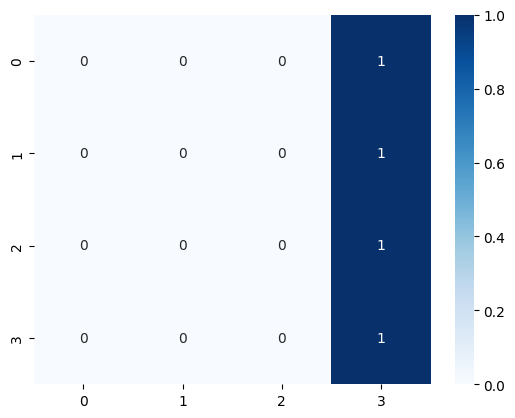

In [10]:
X_train = X_train_orig.copy()
y_train = y_train_orig.copy()
X_test = X_test_orig.copy()
y_test = y_test_orig.copy()
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

clf = SVC(C=0.01, kernel='rbf', gamma=0.01, decision_function_shape='ovr')
clf.fit(X_train, y_train)
y_test_preds = clf.predict(X_test)

print('============ Classification metrics ============')
print(classification_report(y_test, y_test_preds))
sns.heatmap(confusion_matrix(y_test, y_test_preds, normalize='true'), annot=True, cmap='Blues')